# LCPA 23-24 - "Hierarchical mergers of binary black holes"


<center><h1>Group 07</h1></center>


<center><style>
table {
    font-size: 24px;
}
</style></center>

| Last Name          | First Name            |Student Number|
|--------------------|-----------------------|----------------|
| Bertinelli         | Gabriele              |2103359         |
| Boccanera          | Eugenia               |                |
| Cacciola           | Martina               |2097476         |
| Lovato             | Matteo                |                |           


# **<span style="color:red"> TO-DO: </span>**

- **Plots**:
  - Mass distribution hist -> maybe select 3 met. Same met diff hosting body. Show median
  - N° of generation per hosting body
  - BH_mass vs escape vel 
  - Mass vs met
  - Other distribution plot: mass vs mass and others

- **Data**:
  - Filter data for time_merge $\leq$ t_H $ \sim 13.6\, Gyr$

- **Visualization**:
  - Do some PCA(?) -> maybe time consuming and useless

- **Models**:
  - Implement functions for simple XGBoost, and GridSearch XGBoost
  - Compare results between RF and XGB
  - Function for SHAP values: violin and bar plot 

- **Analysis**:
  - The idea is to split the analysis in 2 parts:
    - Based on the features of the BHs generations, understand to which host body belongs the binary system: as label used `label` -> so we are classifying the system with labels the host body (0 -> GC, 1 -> nSC, 2 -> ySC). The features importance will tell us which features are the most important in understand where a system belongs.
    - Analyze each host body independently. To each system a new label `label_ngen` is given. 0 if a binary systems do not evolve and remain in the 2nd generation; 1 if the system evolves further from the 2nd gen.  
    Analyzing the features importance of this classification problem will tell us which are the most important features that make a binary BH system evolve further from the 2nd gen. To understand in great detail this, we'll use the SHAP values (below there's a in-depth discusssion) 
  

### SHAP Values

[SHAP](https://shap.readthedocs.io/en/latest/) (SHapley Additive exPlanations) values are a method used to explain the predictions of machine learning models. They were introduced by [Lundberg and Lee](https://papers.nips.cc/paper_files/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf) in 2017 and are based on cooperative game theory.

SHAP values provide a way to allocate the contribution of each feature in a prediction model to the final prediction. They aim to quantify the impact of each feature on the prediction outcome by considering all possible combinations of features and calculating the contribution of each feature in each combination.

The core idea behind SHAP values is the concept of [Shapley values](https://en.wikipedia.org/wiki/Shapley_value), which is a method for fairly distributing the payout of a cooperative game among the players based on their individual contributions. In the context of machine learning models, the features are treated as players, and the prediction outcome is the payout.

To calculate SHAP values, a baseline reference is established, which serves as a starting point for the feature contributions. Then, different combinations of features are created, and for each combination, the model predictions are observed. The contribution of each feature is determined by comparing the predictions with and without the feature included.

SHAP values provide several advantages in interpreting machine learning models. They offer a unified framework for feature importance measurement that is both consistent and locally accurate. They also satisfy desirable properties such as consistency, meaning that if a feature is removed or added, the SHAP values change accordingly. Furthermore, SHAP values can be used to explain individual predictions as well as provide an overview of feature importance across the entire dataset.

In our study, we employed three types of visualizations to gain insights into the importance of each feature*.

Summary plot (bar type) for global inspection
This kind of plot examine the mean absolute SHAP value for each feature across all of the data. This quantifies, on average, the magnitude of each feature's contribution towards the predicted label. If a feature has a high mean SHAP value, it suggests that it generally has a strong influence on the predictions. Conversely, a low mean SHAP value indicates that the feature has less impact on the model's predictions. Mean absolute SHAP values are essentially a drop-in replacement for more traditional feature importance measures but have two key advantages:

Mean absolute SHAP values are more theoretically rigorous, and relate to which features impact predictions most. Conventional feature importances are measured in more abstract and algorithm-specific ways, and are determined by how much each feature improves the model's predictive performance.
Mean absolute SHAP values have intuitive units, like the target variable. Feature importances are often expressed in counterintuitive units based on complex concepts such as tree algorithm node impurities.
The features are presented in descending order of importance, with the most significant feature listed at the top and the less significant features listed towards the bottom.

Summary plot (bar type) for labels inspection
We created separate plots for each label to gain a more accurate understanding of the feature importance. By examining the importance of features for each label individually, we obtained specific insights into their contributions to the prediction accuracy for each class.

Summary plot (violin type) for each label (evolution channel)
This is the most useful type of plot for our study. A SHAP violin plot provides a visual representation of the distribution of SHAP values for different features in the model. It helps in understanding the impact of each feature on the model's predictions.

Vertical Axis: The vertical axis represents the features in the model. The features are presented in descending order of importance.

Horizontal Axis: The horizontal axis represents the range of SHAP values. It spans from negative to positive values, indicating the direction and magnitude of the feature's influence on the predictions.

Violin Shape: Each violin-shaped distribution represents the density of the SHAP values for a specific feature. The width of the violin at a given point represents the density or frequency of SHAP values at that point.

A wider section of the violin indicates a higher density of SHAP values, indicating a stronger influence of the feature on the predictions.
A narrower section of the violin indicates a lower density of SHAP values, suggesting a weaker influence.
Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.

The SHAP violin plot allows you to compare the distributions of SHAP values across different features. It helps identify features that have consistent and impactful contributions (wider violins with higher densities) and those that have less influence (narrower violins with lower densities).

The plot can also reveal features with bimodal or asymmetric distributions, indicating the presence of different subgroups or distinct patterns in the data that affect the predictions differently.

* ref1: https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/
* ref2: https://medium.com/dataman-in-ai/explain-your-model-with-the-shap-values-bc36aac4de3d

## Import modules

In [1]:
import numpy as np
import pandas as pd
import polars as pl 

import matplotlib.pyplot as plt
import hvplot
import seaborn as sns

import numpy.typing as npt
from typing import Optional, Tuple, Callable, Union, List

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

## Dataset creation

In [2]:
def create_dataset(path: str, folders: List[str], mets: List[str], cols: List[str]) -> pl.DataFrame:

    """
    Function that takes in input a list of folders and a list of metallicities.
    It returns a polars lazy DataFrame with all the data from the folders and metallicities.

    :params path: path to the data parent folder (remember to add the final '/')
    :params folders: list of selected folders
    :params mets: list of selected metallicities
    :params cols: list of selected columns original names
    :return: a `polars` DataFrame with all the data from the folders and metallicities
    """

    name = 'nth_generation.txt'

    col_name = ['c' + str(i) for i in range(28)]

    for i in range(len(folders)):
        for j in range(len(mets)):

            
            file_q = pl.scan_csv(path + folders[i] + '/Dyn/' + 
                                mets[j] + '/' + name, 
                                separator = ' ', has_header=True,
                                new_columns = col_name).select(cols) # select bold columns -> most important for this analysis
            
            
            met = pl.Series([float(mets[j]) for k in range(file_q.collect().height)]) # add metallicity column

            # univocal ID given by the original ID . metallicity folder . hosting obj folder
            new_id = pl.Series(file_q.select(pl.col('c0')).cast(pl.String).collect() + '.' + str(j) + '.' + str(i))#.cast(pl.Float64)

            # hosting object label set: 0 -> GC, 1 -> nSC, 2 -> ySC
            label = pl.Series([i for _ in range(file_q.collect().height)])

            file_q = file_q.with_columns(label.alias('label'), met.alias('met'), new_id.alias('c0')) 

            if i == 0 and j==0:
                df = file_q.collect()
                
            else:
                
                df = df.vstack(file_q.collect())

    return df


def rename_columns(df: pl.DataFrame, new_cols: List[str]) -> pl.DataFrame:
    """
    Function that takes in input a DataFrame and a list of new column names (apart from the last two columns).
    It returns a DataFrame with renamed columns.

    :params df: input `polars` or `pandas` DataFrame 
    :params new_cols: list of new column names
    :return: a `polars` or `pandas` DataFrame with renamed columns
    """
    old_cols = df.columns

    rename_dict = {old_cols[i]: new_cols[i] for i in range(len(old_cols)-2)}
    df = df.rename(rename_dict)

    return df


def get_label_ngen(df: pl.DataFrame) -> pl.DataFrame:

    """
    Function that takes in input a DataFrame and returns a new column with the label for the nth generation.
     - 0 if the ID is unique, meaning that the binary systems did not evolve further (from the 2nd generation); 
     - 1 if the ID is not unique, meaning that the binary systems evolved further (from the 2nd generation).

    :param df: DataFrame
    :return: DataFrame
    """
    id_counts = df.group_by('ID').agg(pl.count('ID').alias('count'))

    # Join the count information back to the original DataFrame
    df = df.join(id_counts, on='ID', how='left')

    # Add the new column based on your condition
    df = df.with_columns(
        pl.when(df['count'] > 1)
        .then(1)
        .otherwise(0)
        .alias('label_ngen')
    )

    # Drop the temporary count column if needed
    df = df.drop('count')

    return df

In [3]:
path='./data/'

folder = ['GC_chi01_output_noclusterevolv', 'NSC_chi01_output_noclusterevolv',
               'YSC_chi01_output_noclusterevolv']
    
metallicity = ['0.0002', '0.002', '0.02', '0.0004', '0.004', '0.006', '0.0008',
                   '0.008', '0.0012', '0.012', '0.0016', '0.016']

cols = ['c0', 'c1', 'c2', 'c3', 'c4', 'c7', 'c8', 'c9', 'c13', 'c15', 'c16', 'c17', 'c25', 'c27'] # select bold columns -> most important for this analysis

new_cols = ['ID', 'bh_mass1', 'bh_mass2', 'spin1', 'spin2', 'semimajor', 'i_ecc', 'time_dyn', 'time_merge', 
'remnant_mass', 'remnant_spin', 'escape_vel', 'cluster_mass', 'n_gen']

In [4]:
df = create_dataset(path, folder, metallicity, cols)

df = rename_columns(df, new_cols)

df = get_label_ngen(df)

In [6]:
df.head()

ID,bh_mass1,bh_mass2,spin1,spin2,semimajor,i_ecc,time_dyn,time_merge,remnant_mass,remnant_spin,escape_vel,cluster_mass,n_gen,label,met,label_ngen
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64,i32
"""2.0.0""",28.497396,23.848129,0.734705,0.014536,118.322458,0.660875,73.920947,1746.620064,49.029268,0.816124,43.17523,456627.739325,2,0,0.0002,0
"""18.0.0""",38.172095,29.913274,0.753993,0.161852,378.031535,0.406799,38.064151,1712.47759,63.511846,0.840459,42.843056,375550.638468,2,0,0.0002,0
"""34.0.0""",60.53033,53.519905,0.720625,0.162188,608.965749,0.936663,240.687784,2461.291832,106.560909,0.825812,118.780296,5.4067e6,2,0,0.0002,0
"""38.0.0""",14.480868,13.043004,0.725751,0.111623,219.843013,0.361773,691.059977,7757.376544,25.747022,0.81898,76.422227,1.6841e6,2,0,0.0002,0
"""103.0.0""",19.224383,15.611048,0.742771,0.208234,28.765131,0.490608,2000.834621,7287.34974,32.475861,0.840732,103.880881,4.2546e6,2,0,0.0002,0


### Data prep

In [5]:
def data_preprocessing(df: pl.DataFrame, n_sample: int, label: str, test_size: float, random_state: int=42) -> Tuple[pd.DataFrame, pd.DataFrame, npt.NDArray, npt.NDArray, npt.NDArray, npt.NDArray]:
    
    """
    Function that takes in input a `polars` DataFrame and returns the preprocessed data for the ML model.

    :params df: input `polars` DataFrame, that will be converted into a `pandas` DataFrame
    :params n_samples: number of samples to select
    :params label: label column name
    :params random_state: random state for reproducibility
    :params test_size: test size for the train/test split
    :return: a tuple with the preprocessed data: X, y, X_train, y_train, X_test, y_test
    
    """

    df =  df.to_pandas()

    if len(df[label].unique()) == 2:

        label_counts = df[label].value_counts()
    
        # Separate majority and minority classes
        df_majority = df[df[label]==label_counts.idxmax()]
        df_minority = df[df[label]==label_counts.idxmin()]

        # Downsample majority class
        df_majority_downsampled = resample(df_majority, 
                                        replace=False,    # sample without replacement
                                        n_samples=df_minority.shape[0],     # to match minority class
                                        random_state=random_state) # reproducible results
        
        # Combine minority class with downsampled majority class
        df_balanced = pd.concat([df_majority_downsampled, df_minority])

    else: 

        label_counts = df[label].value_counts()

        df_majority = df[df[label]==label_counts.idxmax()]
        df_minority = df[df[label]==label_counts.idxmin()]
        df_middle = df[(df[label] != label_counts.idxmax()) & (df[label] != label_counts.idxmin())]

        # Downsample majority class
        df_majority_downsampled = resample(df_majority, 
                                        replace=False,    # sample without replacement
                                        n_samples=df_minority.shape[0],     # to match minority class
                                        random_state=random_state) # reproducible results
        
        df_middle_downsampled = resample(df_middle,
                                        replace=False,
                                        n_samples=df_minority.shape[0],
                                        random_state=random_state)

        # Combine minority class with downsampled majority class
        df_balanced = pd.concat([df_majority_downsampled, df_middle_downsampled, df_minority])

    # Display new class counts
    print(df_balanced[label].value_counts())

    # Now let's select n shuffled samples
    df_sample = df_balanced.sample(n=n_sample, random_state=random_state)

    # Define features and target
    X = df_sample.drop(['ID', 'label', 'n_gen', 'label_ngen'], axis=1)
    y = df_sample[label]

    print()
    print('Label count:', y.value_counts())

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Initialize the scaler
    scaler = MinMaxScaler()

    # Fit the scaler to the training data and transform
    X_train = scaler.fit_transform(X_train)

    # Transform the test data
    X_test = scaler.transform(X_test)

    return X, y, X_train, y_train, X_test, y_test

### Plots

Let's start by comparing the main features (mass, spin, escape velocity) between different clusters.

### Mass distribution

Non so perchè non si veda il label 2. Va sistemato l'aspetto estetico

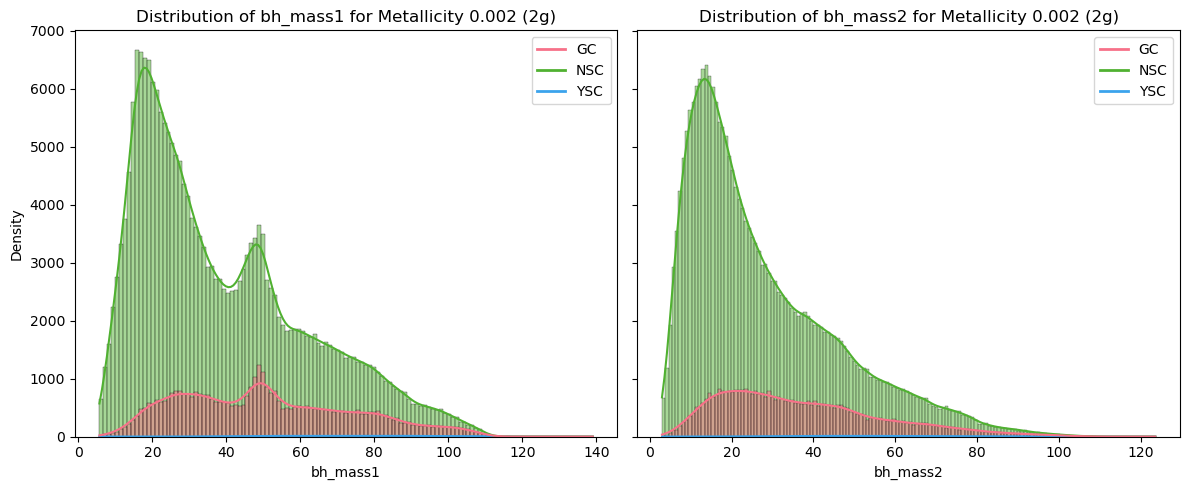

Mean Mass per Cluster:
 label  mean_mass_bh1  mean_mass_bh2
     2      73.146283      55.895977
     0      50.893290      37.012667
     1      38.977806      27.836428


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Filter the DataFrame for metallicity 0.002
df_metallicity_002 = df.filter((df['met'] == 0.002) & (df['label_ngen'] == 0))

# Create a custom color palette with the necessary number of colors
custom_palette = sns.color_palette("husl", n_colors=len(df_metallicity_002['label'].unique()))

# Create two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot for bh_mass1
sns.histplot(data=df_metallicity_002.to_pandas(), x='bh_mass1', hue='label', kde=True, ax=axes[0], palette=custom_palette)
axes[0].set_title('Distribution of bh_mass1 for Metallicity 0.002 (2g)')
axes[0].set_xlabel('bh_mass1')
axes[0].set_ylabel('Density')

# Plot for bh_mass2
sns.histplot(data=df_metallicity_002.to_pandas(), x='bh_mass2', hue='label', kde=True, ax=axes[1], palette=custom_palette)
axes[1].set_title('Distribution of bh_mass2 for Metallicity 0.002 (2g)')
axes[1].set_xlabel('bh_mass2')
axes[1].set_ylabel('Density')

# Set legend labels manually
legend_labels = {0: 'GC', 1: 'NSC', 2: 'YSC'}
custom_lines = [Line2D([0], [0], color=custom_palette[i], lw=2, label=legend_labels[i]) for i in legend_labels]

# Add legend
for ax in axes:
    ax.legend(handles=custom_lines)

# Adjust layout
plt.tight_layout()
plt.show()

# Compute the mean mass for primary and secondary bh in each cluster
mean_mass_per_cluster = df_metallicity_002.group_by('label').agg(
    pl.col('bh_mass1').mean().alias('mean_mass_bh1'),
    pl.col('bh_mass2').mean().alias('mean_mass_bh2')
)

# Display the mean mass per cluster 
print("Mean Mass per Cluster:")
print(mean_mass_per_cluster.to_pandas().to_string(index=False))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


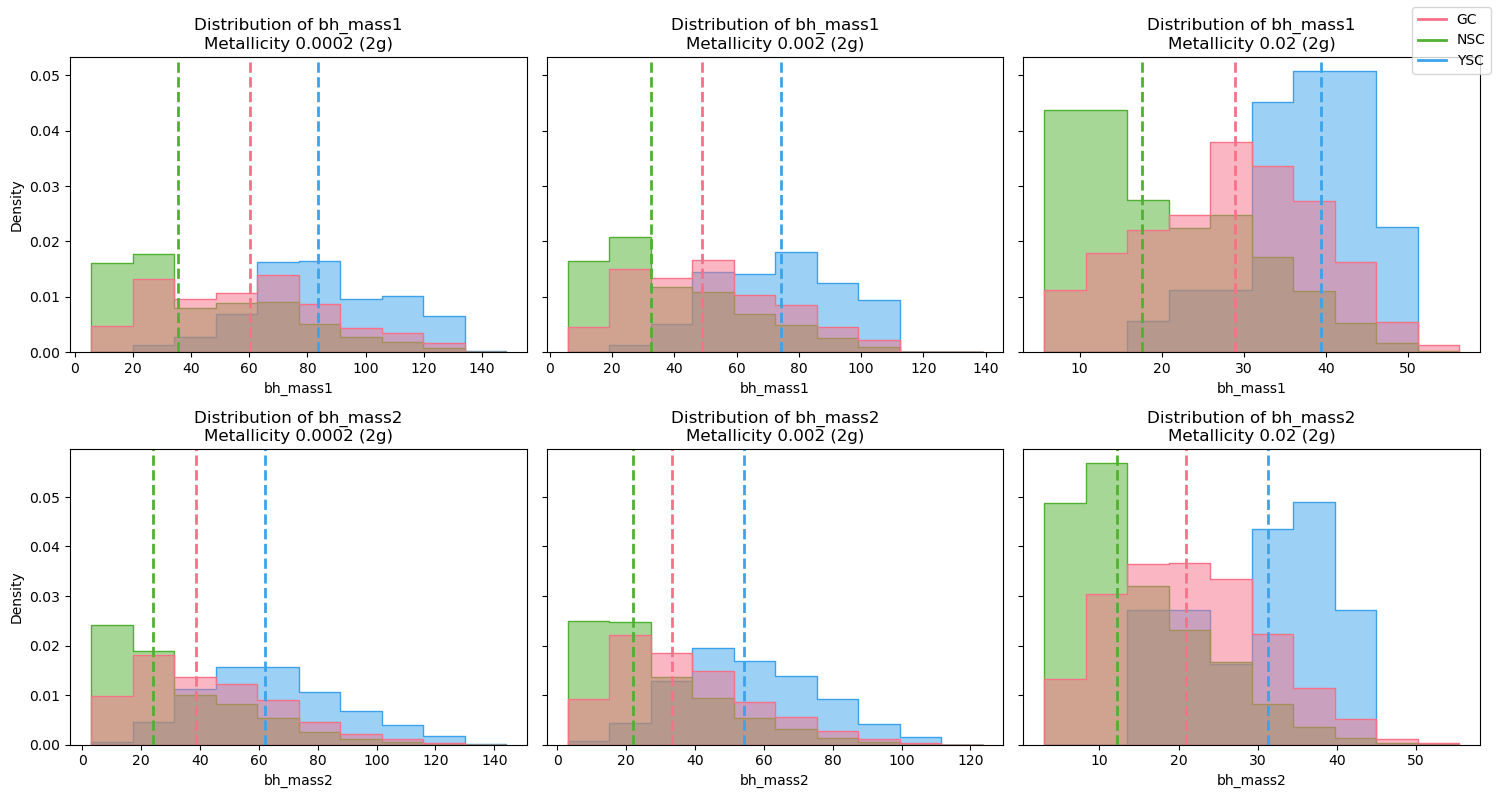

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Specify the metallicities to consider
metallicities = ['0.0002', '0.002', '0.02']

# Create subplots for each metallicity
fig, axes = plt.subplots(2, len(metallicities), figsize=(15, 8), sharey='row')

# Loop through each metallicity and each variable (bh_mass1 and bh_mass2)
for i, met in enumerate(metallicities):
    # Filter the DataFrame for the current metallicity
    df_metallicity = df.filter((df['met'] == float(met)) & (df['label_ngen'] == 0))

    # Create a custom color palette with the necessary number of colors
    custom_palette = sns.color_palette("husl", n_colors=len(df_metallicity['label'].unique()))

    # Plot histogram for bh_mass1
    sns.histplot(data=df_metallicity.to_pandas(), x='bh_mass1', hue='label', bins=10, kde=False, ax=axes[0, i], palette=custom_palette, element="step", stat="density", common_norm=False, alpha=0.5)
    axes[0, i].set_title(f'Distribution of bh_mass1\nMetallicity {met} (2g)')
    axes[0, i].set_xlabel('bh_mass1')
    axes[0, i].set_ylabel('Density')

    # Plot histogram for bh_mass2
    sns.histplot(data=df_metallicity.to_pandas(), x='bh_mass2', hue='label', bins=10, kde=False, ax=axes[1, i], palette=custom_palette, element="step", stat="density", common_norm=False, alpha=0.5)
    axes[1, i].set_title(f'Distribution of bh_mass2\nMetallicity {met} (2g)')
    axes[1, i].set_xlabel('bh_mass2')
    axes[1, i].set_ylabel('Density')

    # Add vertical lines for median values in bh_mass1
    for label in df_metallicity['label'].unique():
        median_bh_mass1 = df_metallicity.filter(df_metallicity['label'] == label).to_pandas()['bh_mass1'].median()
        axes[0, i].axvline(median_bh_mass1, color=custom_palette[label], linestyle='dashed', linewidth=2)

    # Add vertical lines for median values in bh_mass2
    for label in df_metallicity['label'].unique():
        median_bh_mass2 = df_metallicity.filter(df_metallicity['label'] == label).to_pandas()['bh_mass2'].median()
        axes[1, i].axvline(median_bh_mass2, color=custom_palette[label], linestyle='dashed', linewidth=2)

    # Remove legend for individual plots
    axes[0, i].legend().set_visible(False)
    axes[1, i].legend().set_visible(False)

# Add legend for all subplots
legend_labels = {0: 'GC', 1: 'NSC', 2: 'YSC'}
custom_lines = [Line2D([0], [0], color=custom_palette[i], lw=2, label=legend_labels[i]) for i in legend_labels]
fig.legend(handles=custom_lines, loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()

### Spin distribution

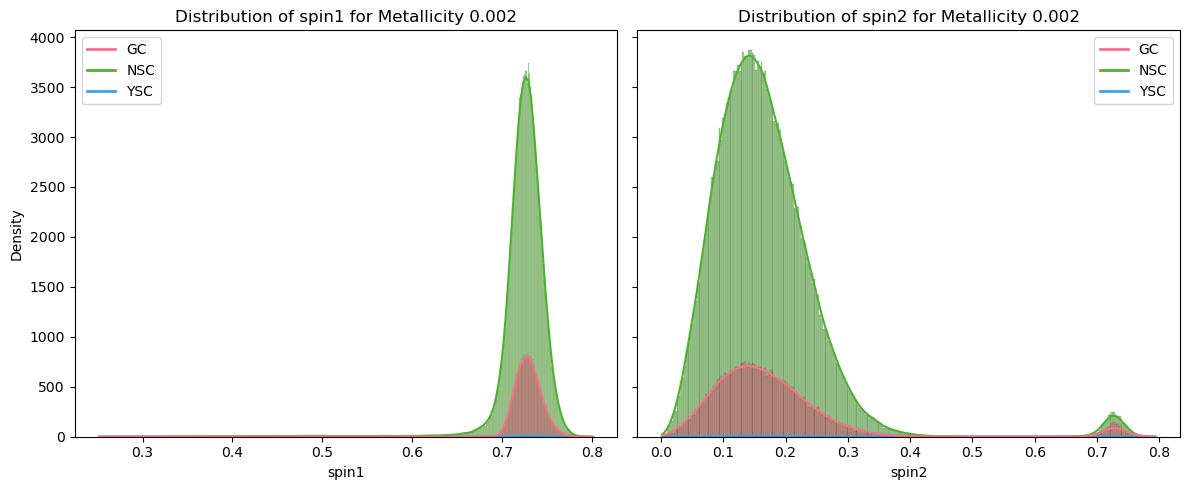

Mean Spin per Cluster:
 label  mean_spin1  mean_spin2
     1    0.723444    0.166919
     2    0.728309    0.231898
     0    0.729352    0.178553


In [47]:
# Filter the DataFrame for metallicity 0.002
df_metallicity_002 = df.filter((df['met'] == 0.002) & (df['label_ngen'] == 0))

# Create a custom color palette with the necessary number of colors
custom_palette = sns.color_palette("husl", n_colors=len(df_metallicity_002['label'].unique()))

# Create two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot for spin1
sns.histplot(data=df_metallicity_002.to_pandas(), x='spin1', hue='label', kde=True, ax=axes[0], palette=custom_palette)
axes[0].set_title('Distribution of spin1 for Metallicity 0.002')
axes[0].set_xlabel('spin1')
axes[0].set_ylabel('Density')

# Plot for spin2
sns.histplot(data=df_metallicity_002.to_pandas(), x='spin2', hue='label', kde=True, ax=axes[1], palette=custom_palette)
axes[1].set_title('Distribution of spin2 for Metallicity 0.002')
axes[1].set_xlabel('spin2')
axes[1].set_ylabel('Density')

# Set legend labels manually
legend_labels = {0: 'GC', 1: 'NSC', 2: 'YSC'}
custom_lines = [Line2D([0], [0], color=custom_palette[i], lw=2, label=legend_labels[i]) for i in legend_labels]

# Add legend
for ax in axes:
    ax.legend(handles=custom_lines)

# Adjust layout
plt.tight_layout()
plt.show()

# Compute the mean spin for spin1 and spin2 in each cluster
mean_spin_per_cluster = df_metallicity_002.group_by('label').agg(
    pl.col('spin1').mean().alias('mean_spin1'),
    pl.col('spin2').mean().alias('mean_spin2')
)

# Display the mean spin per cluster
print("Mean Spin per Cluster:")
print(mean_spin_per_cluster.to_pandas().to_string(index=False))

### Mass of the BH remnant resulting from the merger

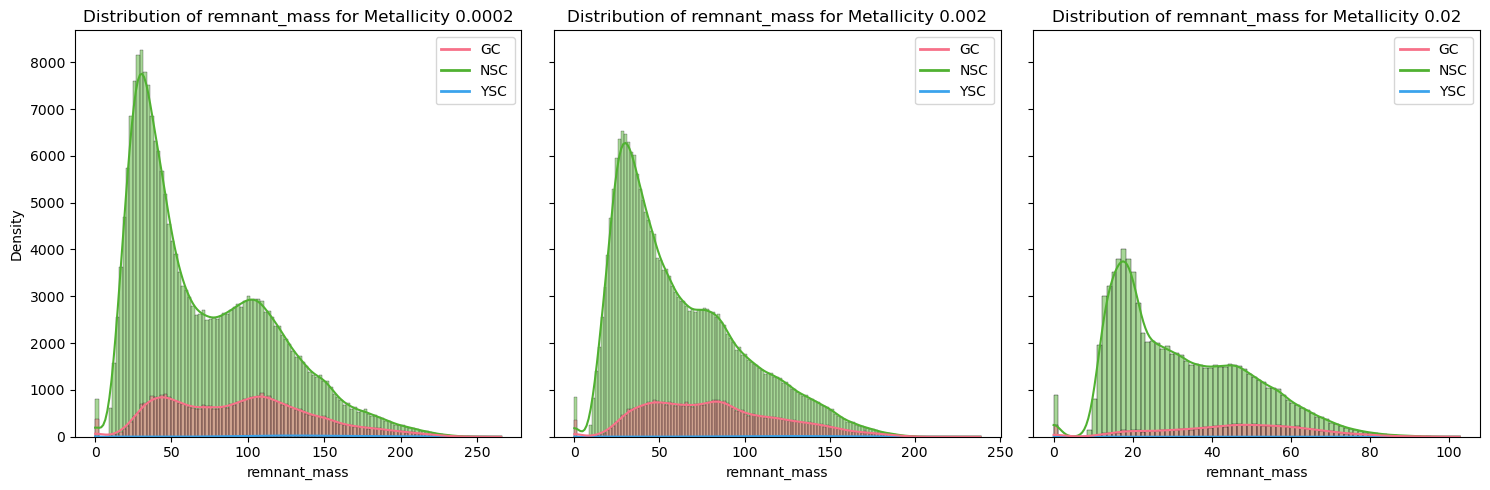

In [48]:
# Specify the metallicities to consider
metallicities = ['0.0002', '0.002', '0.02']

# Create subplots for each metallicity
fig, axes = plt.subplots(1, len(metallicities), figsize=(15, 5), sharey=True)

# Loop through each metallicity
for i, met in enumerate(metallicities):
    # Filter the DataFrame for the current metallicity
    df_metallicity = df.filter((df['met'] == float(met)) & (df['label_ngen'] == 0))

    # Create a custom color palette with the necessary number of colors
    custom_palette = sns.color_palette("husl", n_colors=len(df_metallicity['label'].unique()))

    # Plot for remnant_mass
    sns.histplot(data=df_metallicity.to_pandas(), x='remnant_mass', hue='label', kde=True, ax=axes[i], palette=custom_palette)
    axes[i].set_title(f'Distribution of remnant_mass for Metallicity {met}')
    axes[i].set_xlabel('remnant_mass')
    axes[i].set_ylabel('Density')

    # Set legend labels manually
    legend_labels = {0: 'GC', 1: 'NSC', 2: 'YSC'}
    custom_lines = [Line2D([0], [0], color=custom_palette[i], lw=2, label=legend_labels[i]) for i in legend_labels]

    # Add legend
    axes[i].legend(handles=custom_lines)

# Adjust layout
plt.tight_layout()
plt.show()

Idea: distinguish between different numbers of generation. But label_ngen is 0 or 1?

### Spin of BH remnant

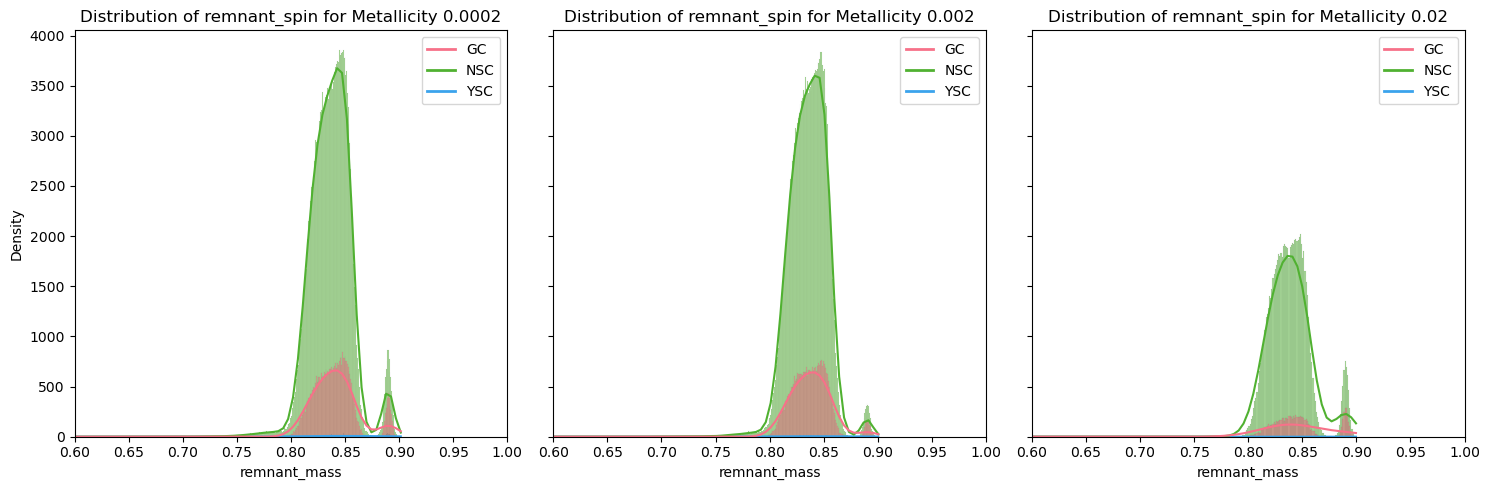

In [51]:
# Specify the metallicities to consider
metallicities = ['0.0002', '0.002', '0.02']

# Create subplots for each metallicity
fig, axes = plt.subplots(1, len(metallicities), figsize=(15, 5), sharey=True)

# Loop through each metallicity
for i, met in enumerate(metallicities):
    # Filter the DataFrame for the current metallicity
    df_metallicity = df.filter((df['met'] == float(met)) & (df['label_ngen'] == 0))

    # Create a custom color palette with the necessary number of colors
    custom_palette = sns.color_palette("husl", n_colors=len(df_metallicity['label'].unique()))

    # Plot for remnant_mass
    sns.histplot(data=df_metallicity.to_pandas(), x='remnant_spin', hue='label', kde=True, ax=axes[i], palette=custom_palette)
    axes[i].set_title(f'Distribution of remnant_spin for Metallicity {met}')
    axes[i].set_xlabel('remnant_mass')
    axes[i].set_ylabel('Density')

    # Set legend labels manually
    legend_labels = {0: 'GC', 1: 'NSC', 2: 'YSC'}
    custom_lines = [Line2D([0], [0], color=custom_palette[i], lw=2, label=legend_labels[i]) for i in legend_labels]

    # Add legend
    axes[i].legend(handles=custom_lines)
    #Set limits to x-axis
    axes[i].set_xlim(0.6, 1)

# Adjust layout
plt.tight_layout()
plt.show()

### Escape velocity

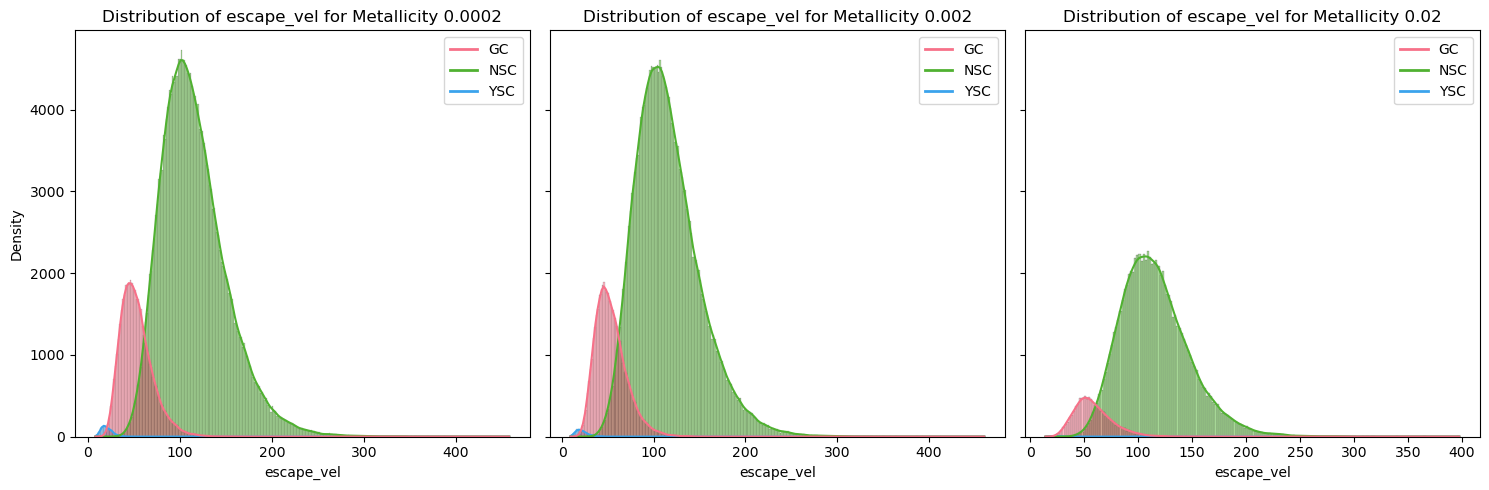

In [57]:
# Specify the metallicities to consider
metallicities = ['0.0002', '0.002', '0.02']

# Create subplots for each metallicity
fig, axes = plt.subplots(1, len(metallicities), figsize=(15, 5), sharey=True)

# Loop through each metallicity
for i, met in enumerate(metallicities):
    # Filter the DataFrame for the current metallicity
    df_metallicity = df.filter((df['met'] == float(met)) & (df['label_ngen'] == 0))

    # Create a custom color palette with the necessary number of colors
    custom_palette = sns.color_palette("husl", n_colors=len(df_metallicity['label'].unique()))

    # Plot for escape_vel
    sns.histplot(data=df_metallicity.to_pandas(), x='escape_vel', hue='label', kde=True, ax=axes[i], palette=custom_palette)
    axes[i].set_title(f'Distribution of escape_vel for Metallicity {met}')
    axes[i].set_xlabel('escape_vel')
    axes[i].set_ylabel('Density')

    # Set legend labels manually
    legend_labels = {0: 'GC', 1: 'NSC', 2: 'YSC'}
    custom_lines = [Line2D([0], [0], color=custom_palette[i], lw=2, label=legend_labels[i]) for i in legend_labels]

    # Add legend
    axes[i].legend(handles=custom_lines)

# Adjust layout
plt.tight_layout()
plt.show()

### Total mass of the stellar cluster

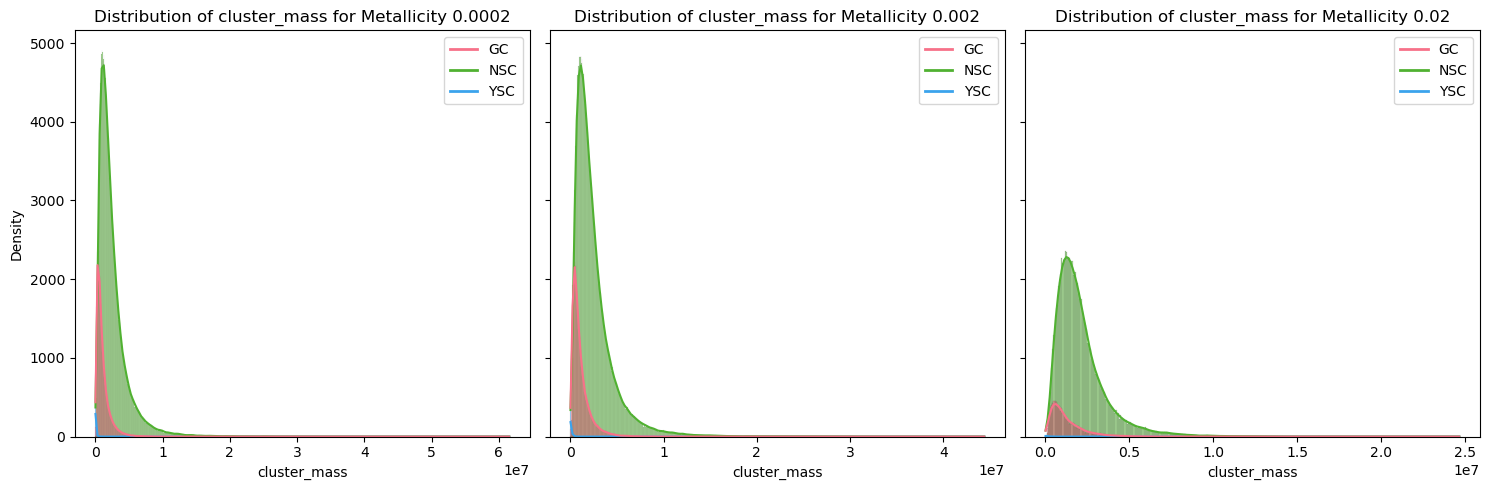

In [56]:
# Specify the metallicities to consider
metallicities = ['0.0002', '0.002', '0.02']

# Create subplots for each metallicity
fig, axes = plt.subplots(1, len(metallicities), figsize=(15, 5), sharey=True)

# Loop through each metallicity
for i, met in enumerate(metallicities):
    # Filter the DataFrame for the current metallicity
    df_metallicity = df.filter((df['met'] == float(met)) & (df['label_ngen'] == 0))

    # Create a custom color palette with the necessary number of colors
    custom_palette = sns.color_palette("husl", n_colors=len(df_metallicity['label'].unique()))

    # Plot for escape_vel
    sns.histplot(data=df_metallicity.to_pandas(), x='cluster_mass', hue='label', kde=True, ax=axes[i], palette=custom_palette)
    axes[i].set_title(f'Distribution of cluster_mass for Metallicity {met}')
    axes[i].set_xlabel('cluster_mass')
    axes[i].set_ylabel('Density')

    # Set legend labels manually
    legend_labels = {0: 'GC', 1: 'NSC', 2: 'YSC'}
    custom_lines = [Line2D([0], [0], color=custom_palette[i], lw=2, label=legend_labels[i]) for i in legend_labels]

    # Add legend
    axes[i].legend(handles=custom_lines)

# Adjust layout
plt.tight_layout()
plt.show()

### BH Mass VS Metallicity - Label: hosting body

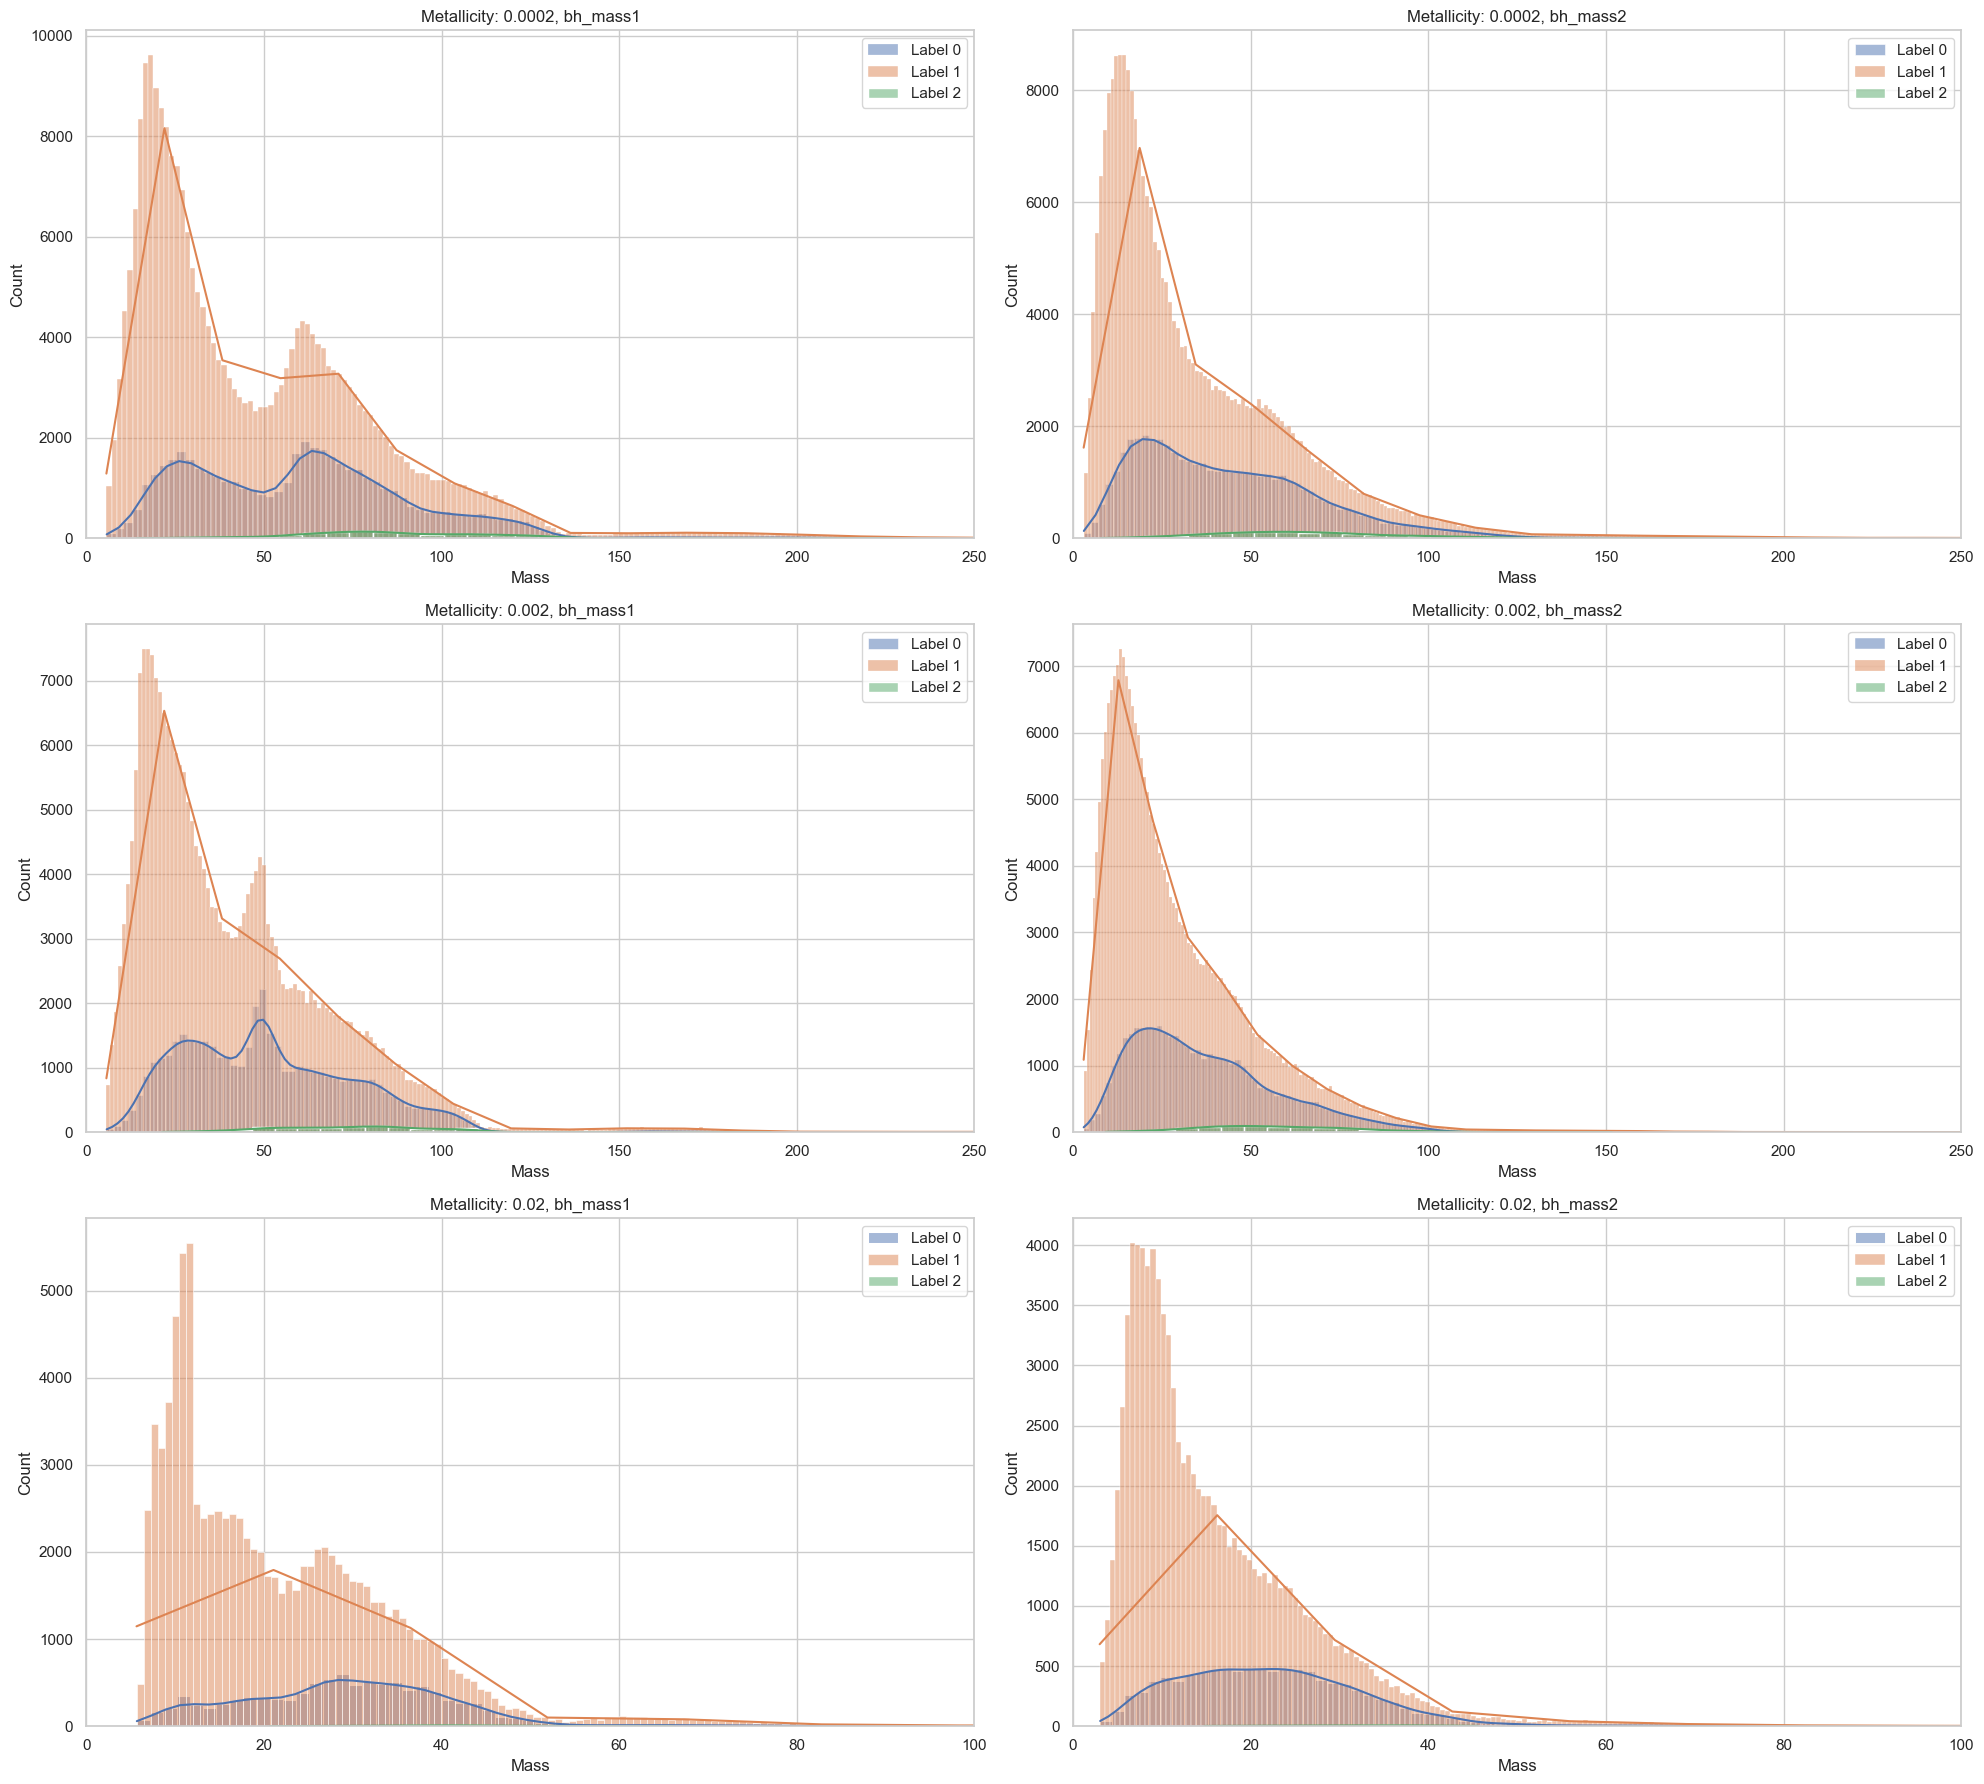

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert selected_metallicities to float
selected_metallicities = [float(x) for x in ['0.0002','0.002','0.02']]

# Create a separate subplot for each metallicity
fig, axs = plt.subplots(len(selected_metallicities), 2, figsize=(20, 6*len(selected_metallicities)))

for i, met in enumerate(selected_metallicities):
    # Filter df for the current metallicity
    df_met = df.filter(df['met'] == met)
    
    # For each label, plot the distribution of the masses
    for label in df_met['label'].unique():
        # Filter df for the current label
        df_label = df_met.filter(df_met['label'] == label)
        
        # Plot the distribution of the masses of the first and second black holes
        for j, bh_mass in enumerate(['bh_mass1', 'bh_mass2']):
            sns.histplot(df_label[bh_mass].to_pandas(), kde=True, ax=axs[i, j], label=f'Label {label}')
            
    
            # Set the title and labels of the subplot
            axs[i, j].set_title(f'Metallicity: {met}, {bh_mass}')
            axs[i, j].set_xlabel('Mass')
            axs[i, j].set_ylabel('Count')
            axs[i, j].legend()

            # Set x-axis limits
            #axs[i, j].set_xlim([0, 250])
            axs[0, 0].set_xlim([0, 250])
            axs[0, 1].set_xlim([0, 250])
            axs[1, 0].set_xlim([0, 250])
            axs[1, 1].set_xlim([0, 250])
            axs[2, 0].set_xlim([0, 100])
            axs[2, 1].set_xlim([0, 100])

plt.tight_layout()
plt.show()

### BH Mass VS Metallicity - Label: number of generation

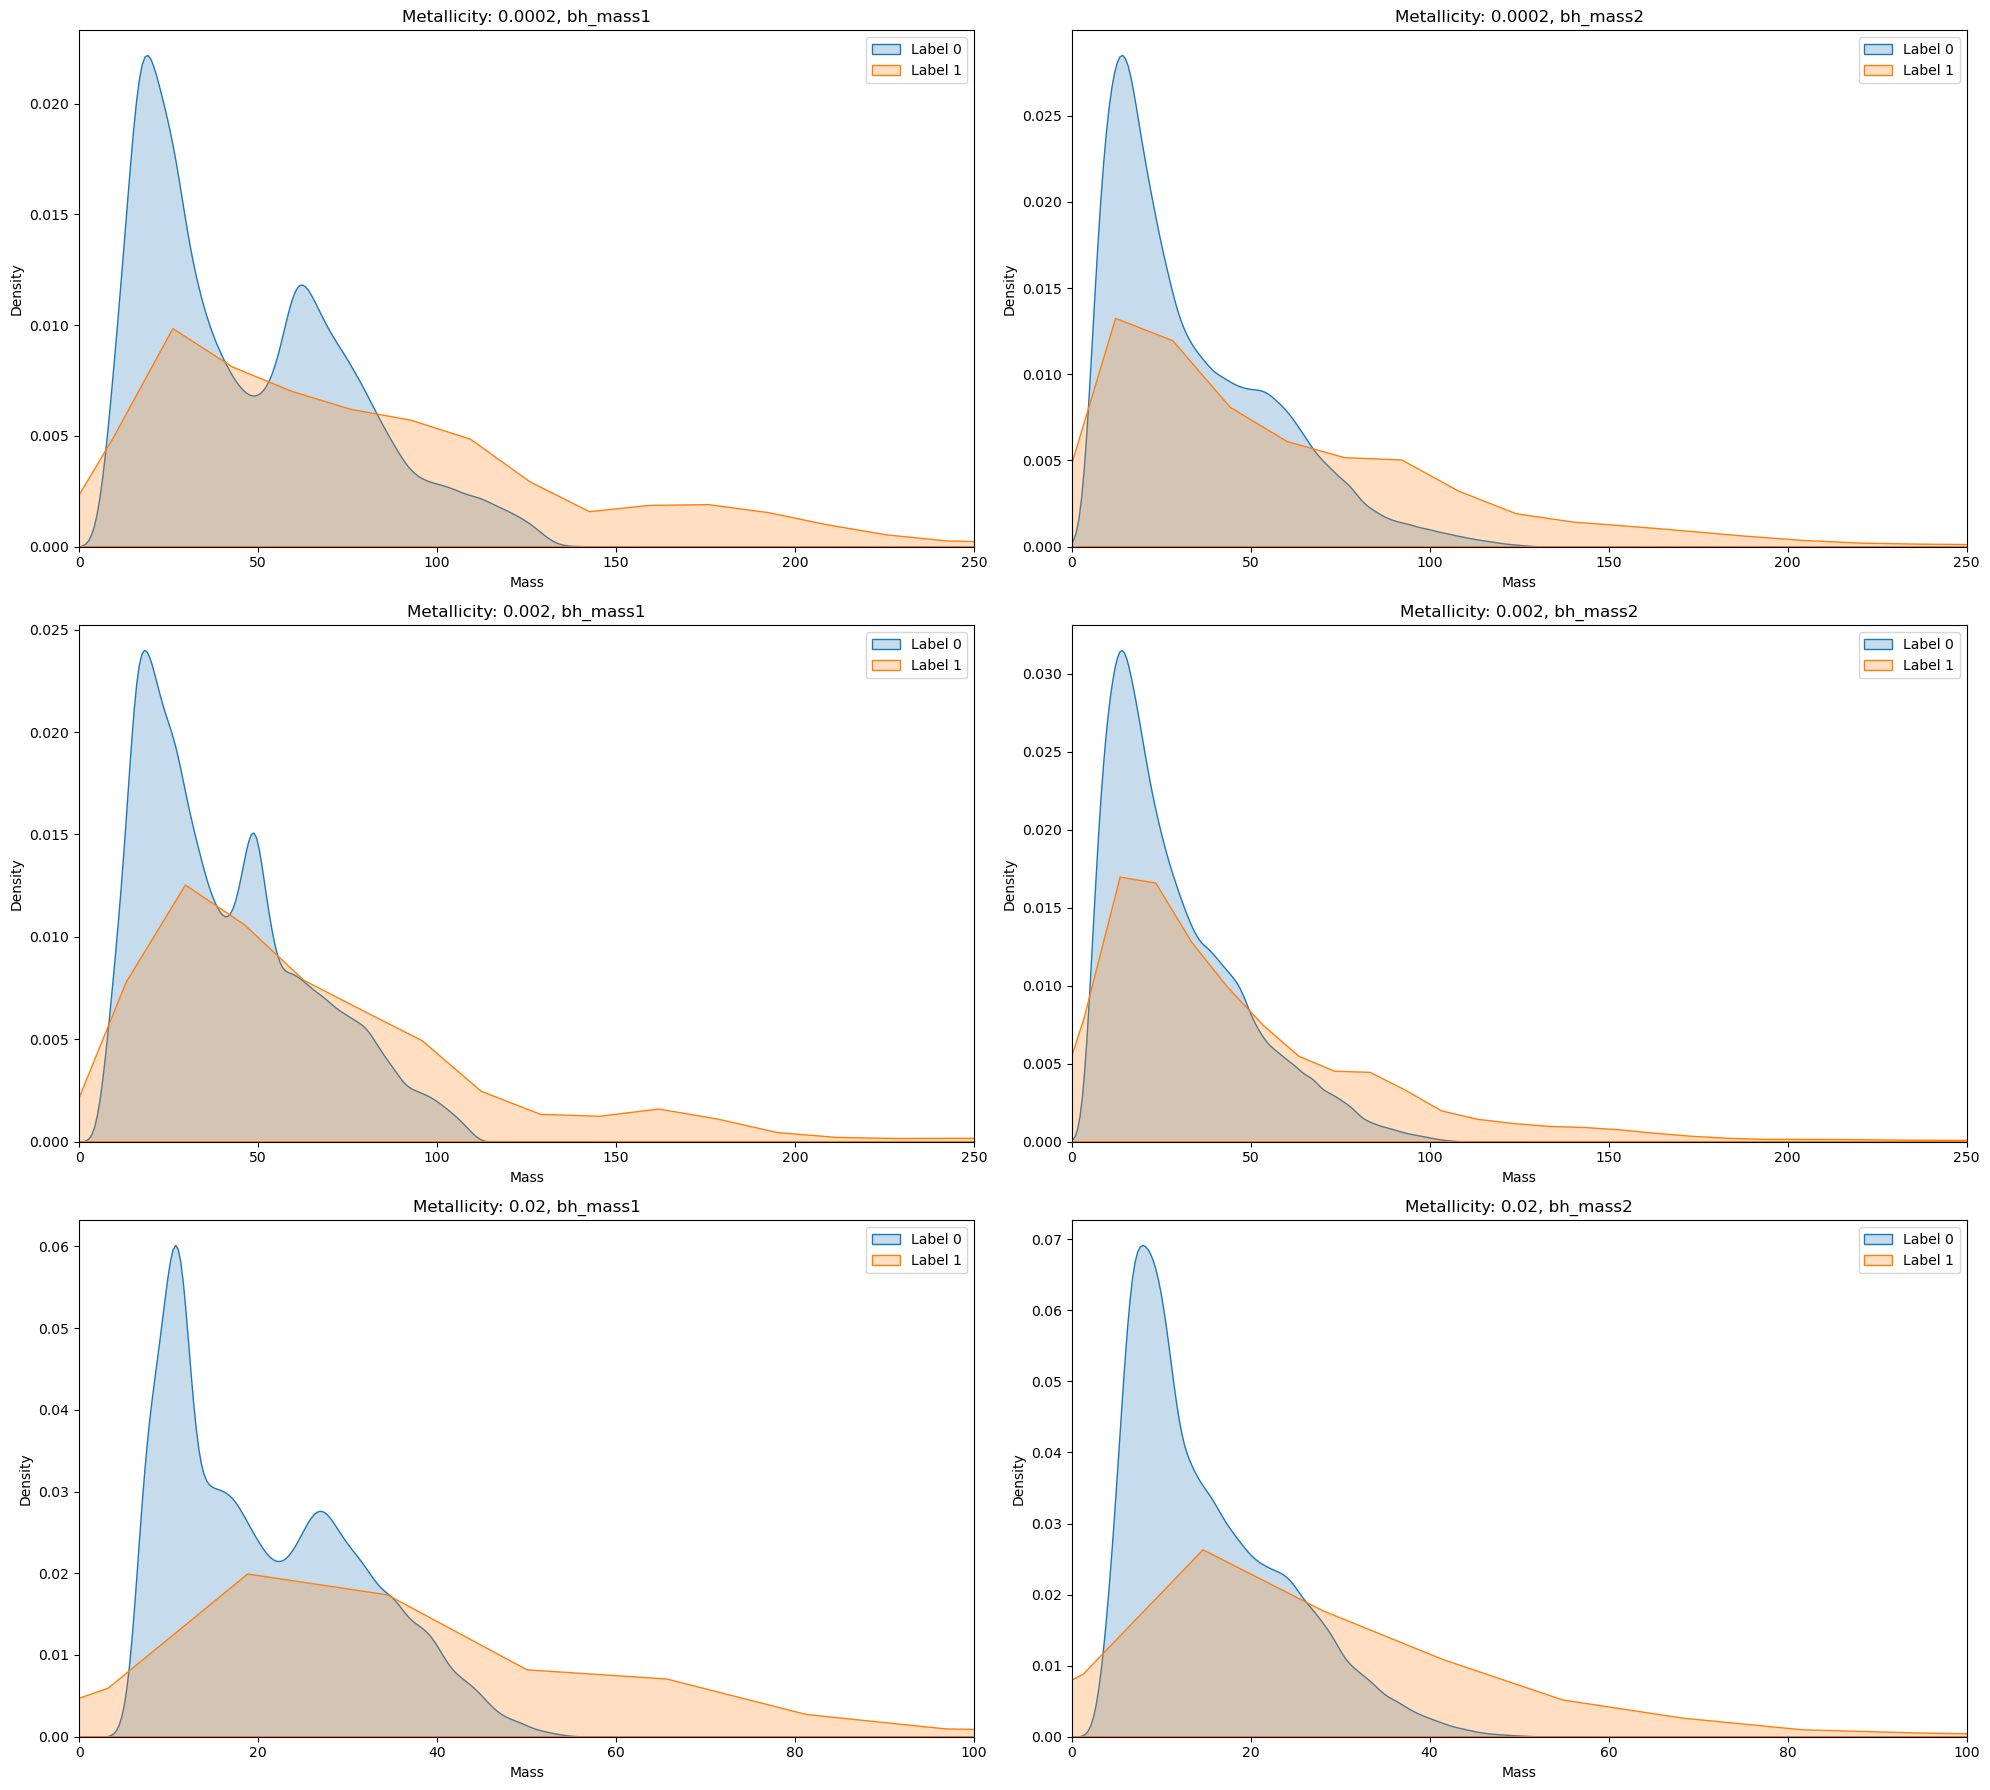

In [14]:
# Convert selected_metallicities to float
selected_metallicities = [float(x) for x in ['0.0002', '0.002', '0.02']]

# Create a separate subplot for each metallicity
fig, axs = plt.subplots(len(selected_metallicities), 2, figsize=(20, 6 * len(selected_metallicities)))

for i, met in enumerate(selected_metallicities):
    # Filter df for the current metallicity
    df_met = df.filter(df['met'] == met)

    # For each label, plot the distribution of the masses
    for label in df_met['label'].unique():
        # Filter df for the current label
        df_label = df_met.filter(df_met['label_ngen'] == label)

        # Plot the distribution of the masses of the first and second black holes using KDE
        for j, bh_mass in enumerate(['bh_mass1', 'bh_mass2']):
            sns.kdeplot(df_label[bh_mass].to_pandas(), fill=True, ax=axs[i, j], label=f'Label {label}', color=f'C{label}')

            # Set the title and labels of the subplot
            axs[i, j].set_title(f'Metallicity: {met}, {bh_mass}')
            axs[i, j].set_xlabel('Mass')
            axs[i, j].set_ylabel('Density')  
            axs[i, j].legend()

            # Set x-axis limits
            axs[0, 0].set_xlim([0, 250])
            axs[0, 1].set_xlim([0, 250])
            axs[1, 0].set_xlim([0, 250])
            axs[1, 1].set_xlim([0, 250])
            axs[2, 0].set_xlim([0, 100])
            axs[2, 1].set_xlim([0, 100])
            
            #axs[i, 0].set_title('Primary BH mass')
            #axs[i, 1].set_title('Secondary BH mass')

plt.tight_layout()
plt.show()


### N° of generation per hosting body

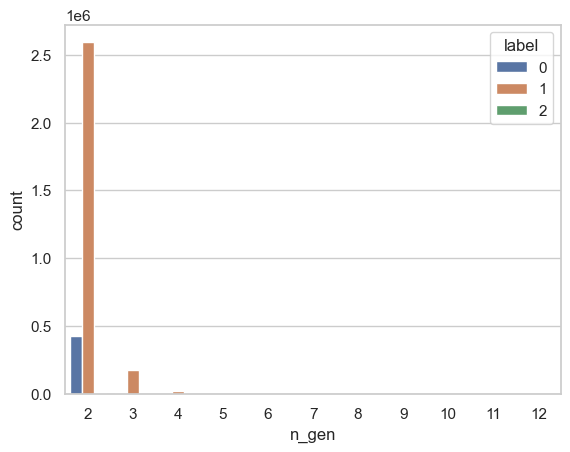

In [40]:
#plot the number of generations for each label
sns.countplot(data=df.to_pandas(), x='n_gen', hue='label')
plt.show()

### BH Mass VS Escape Vel

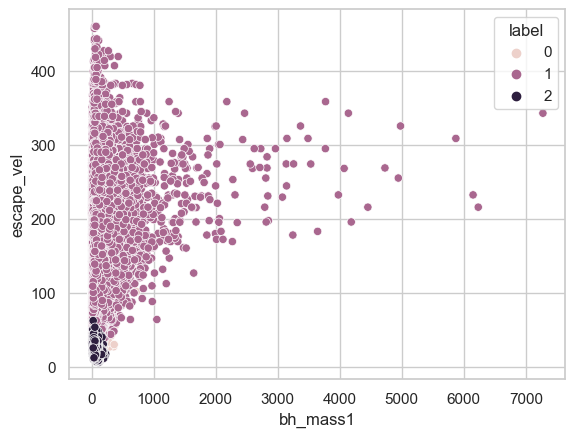

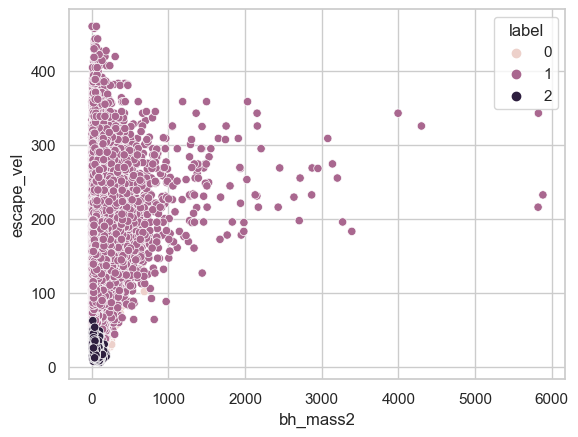

In [37]:
#plot the primary bh masses vs escape velocity
sns.scatterplot(data=df.to_pandas(), x='bh_mass1', y='escape_vel', hue='label')
plt.show()

#plot the secondary bh masses vs escape velocity
sns.scatterplot(data=df.to_pandas(), x='bh_mass2', y='escape_vel', hue='label')
plt.show()

### Mass of the BH remnant VS Metallicity

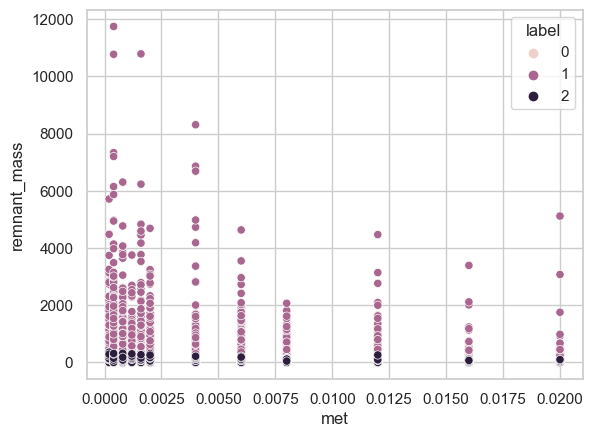

In [43]:
#plot the mass of the bh remnant vs escape velocity
sns.scatterplot(data=df.to_pandas(), x='met', y='remnant_mass', hue='label')
plt.show()

### Simple Random Forest

In [6]:
def simple_RF(X_train: npt.NDArray, y_train: npt.NDArray, X_test: npt.NDArray, random_state: int=42) -> Tuple[RandomForestClassifier, npt.NDArray]:
    
    """
    Function that takes in input the preprocessed data and returns a simple Random Forest model.

    :params X_train: training features
    :params y_train: training target
    :params X_test: testing features
    :params random_state: random state for reproducibility
    :return: a tuple with the model, the predictions target: model, y_pred
    
    """

    # Initialize the Random Forest Classifier
    RF = RandomForestClassifier(n_estimators=10, class_weight='balanced_subsample', criterion='entropy', random_state=random_state)

    # Fit the model to the training data
    RF.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = RF.predict(X_test)

    return RF, y_pred

def model_evaluation(model: RandomForestClassifier, X: npt.NDArray, y: npt.NDArray, X_train: npt.NDArray, y_train: npt.NDArray, X_test: npt.NDArray, y_test: npt.NDArray, y_pred: npt.NDArray) -> None:
    
    """
    Function that takes in input the model and the preprocessed data and returns the evaluation of the model: Training Score, Test Score, Confusion Matrix and Feature Importances.

    :params model: Random Forest model
    :params X: features
    :params y: target
    :params X_train: training features
    :params y_train: training target
    :params X_test: testing features
    :params y_test: testing target
    :params y_pred: model predictions
    :return: None 
    """

    #std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

    # Get feature importances
    importances = model.feature_importances_

    # Convert the importances into one-dimensional 1darray with corresponding df column names as axis labels
    f_importances = pd.Series(importances, X.columns)

    # Sort the array in descending order of the importances
    f_importances.sort_values(ascending=False, inplace=True)

    print("Training Score:", model.score(X_train, y_train))
    print("Test score (Accuracy):    ", model.score(X_test, y_test))
    print()

    # Plot the confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Greys, normalize='true', text_kw={'fontsize': 11})
    plt.title('Confusion Matrix')
    plt.show()

    # Make the bar Plot from f_importances 
    f_importances.plot(x='Features', y='Importance', kind='bar', figsize=(12, 4), rot=45, fontsize=11)#, yerr=std)

### Grid Search CV

In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 300, 500, 800],
    'max_depth': [5, 15, 25, 50],
    'min_samples_split': [5, 10, 15, 20, 30, 40 , 50, 60, 70, 80]
}

def gridsearch_RF(param_grid: dict, cv: int, X_train: npt.NDArray, y_train: npt.NDArray, X_test: npt.NDArray, n_jobs: int, random_state: int=42, verbose: int=2) -> Tuple[RandomForestClassifier, npt.NDArray, dict]:
    
    """
    Function that takes in input the parameter grid and the preprocessed data and returns the best model and the predictions.

    :params param_grid: parameter grid for the Grid Search
    :params cv: cross-validation folds
    :params X_train: training features
    :params y_train: training target
    :params X_test: testing features
    :params random_state: random state for reproducibility
    :params verbose: verbosity level
    :params n_jobs: number of jobs to run in parallel
    :return: a tuple with the best model and the predictions: model, y_pred
    
    """

    RF = RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', random_state=random_state)

    # Initialize the grid search model
    grid_search = GridSearchCV(estimator=RF, param_grid=param_grid, cv=cv, verbose=verbose, n_jobs=n_jobs, return_train_score=True)

    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)

    # Get the best parameters
    best_params = grid_search.best_params_
    best_index = grid_search.best_index_

    print('Best parameters:', best_params)
    print('ID of the best combination:', best_index)

    # Fit the model with the best parameters
    RF_best = RandomForestClassifier(**best_params)
    RF_best.fit(X_train, y_train)

    # Predict on the test set
    y_pred = RF_best.predict(X_test)

    return RF_best, y_pred, grid_search

label
1    7460
0    7460
2    7460
Name: count, dtype: int64

Label count: label
0    1683
1    1676
2    1641
Name: count, dtype: int64
Training Score: 0.99525
Test score (Accuracy):     0.923



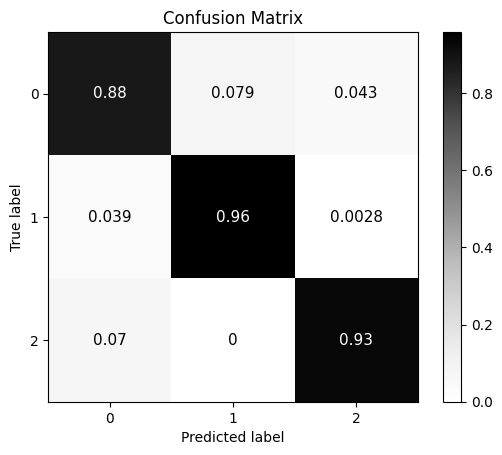

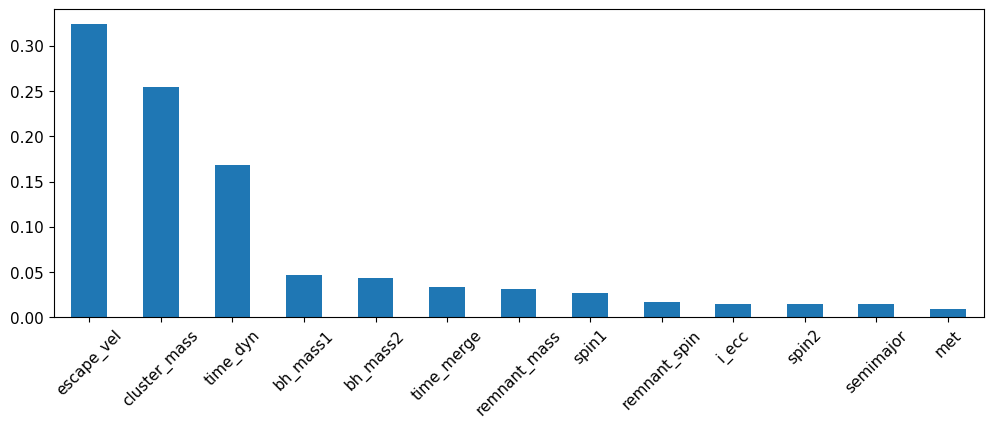

In [19]:
df_1 = df.filter(pl.col('label')==0)
X, y, X_train, y_train, X_test, y_test = data_preprocessing(df, n_sample=5000, label='label', test_size=0.2)


RF, y_pred = simple_RF(X_train, y_train, X_test)

model_evaluation(RF, X, y, X_train, y_train, X_test, y_test, y_pred)

In [ ]:
%%time
X, y, X_train, y_train, X_test, y_test = data_preprocessing(df, n_samples=10000, label='label', random_state=42, test_size=0.2)


RF_best, y_pred, grid_search = gridsearch_RF(param_grid=param_grid, cv=3, X_train=X_train, y_train=y_train, X_test=X_test, n_jobs=25)

model_evaluation(RF_best, X, y, X_train, y_train, X_test, y_test, y_pred)

In [ ]:
def model_scores(grid_search: dict, best_index: int) -> None:

    """
    Function that takes in input the grid search results and the best index and returns the mean test scores plot.

    :params grid_search: grid search results
    :params best_index: best index
    :return: None
    """
    # Get mean test scores
    mean_test_scores = grid_search.cv_results_['mean_test_score']
    mean_train_scores = grid_search.cv_results_['mean_train_score']

    # Plot mean test scores
    plt.figure(figsize=(10, 6))

    plt.plot(range(1, len(mean_test_scores)+1), mean_test_scores, label='Mean Test Score', color='blue')
    plt.plot(range(1, len(mean_train_scores)+1), mean_train_scores, label='Mean Train Score', color='orange')
    plt.xlabel('Index of hyperparameter combination')
    plt.vlines(x=best_index, ymin=0, ymax=1.2, color='green', label='Best combination')
    plt.ylabel('Mean Score')
    plt.legend(loc='best')
    plt.ylim(0.5, 1.1)
    plt.show()

In [ ]:
model_scores(grid_search, best_index=55)

In [ ]:
import shap

# Create object that can calculate shap values
explainer = shap.TreeExplainer(rf)

# Calculate Shap values
shap_values = explainer.shap_values(X_train[:150].values)

In [ ]:
fig = plt.figure()

ax0 = fig.add_subplot(211)
ax0.set_title('Non-evolved - 0')
shap.summary_plot(np.abs(shap_values[0]), X_test[:150], plot_type='violin', show=False)
ax0.set_xlabel('SHAP values (impact on output model)', fontsize=11)



ax1 = fig.add_subplot(212)
ax1.set_title('Evolved - 1')
shap.summary_plot(np.abs(shap_values[1]), X_test[:150], plot_type='violin', show=False)
ax1.set_xlabel('SHAP values (impact on output model)', fontsize=11)


# ax2 = fig.add_subplot(313)
# plt.title('Class 0 - CE')
# shap.summary_plot(shap_values[0], X_test[:150], plot_type='violin', show=False)
# plt.xlabel('SHAP values (impact on output model)', fontsize=11)

plt.subplots_adjust(hspace = 50)
plt.gcf().set_size_inches(7,10)
plt.tight_layout()
plt.show()

In [ ]:
import shap
shap_values = shap.TreeExplainer(rf).shap_values(X_test[:150])
shap.summary_plot(shap_values, X_test[:150])